In [27]:
import torch
import json
import numpy as np
from scipy import interpolate
from scipy.ndimage import gaussian_filter1d



In [28]:
def prepare_medmax(filename):
    with open(filename, 'r') as f:
        simulated_data = json.load(f)

    # Preprocess all spectra with interpolation and Gaussian smoothing
    new_wavenumbers = np.arange(400, 4000, 4)  # Common wavenumber grid
    processed_spectra = {}
    max_intensities = [np.max(data_obj['data']['intensity']) for data_obj in simulated_data]
    median_max_intensity = np.median(max_intensities)

    for data_obj in simulated_data:
        # Get original data
        orig_wavenumbers = np.array(data_obj['data']['wavenumber'])
        orig_intensities = np.array(data_obj['data']['intensity'])
        
        # Interpolate to new grid
        f = interpolate.interp1d(orig_wavenumbers, orig_intensities,
                                bounds_error=False, fill_value=0)
        new_intensities = f(new_wavenumbers)
        
        # Apply Gaussian smoothing with sigma=1
        smoothed = gaussian_filter1d(new_intensities, sigma=1)

        # remove negative values
        smoothed = np.where(smoothed < 0, 0, smoothed)  
        
        # Store processed spectrum
        processed_spectra[data_obj['smiles']] = smoothed

        # Scale down by median of max intensity
        processed_spectra[data_obj['smiles']] = processed_spectra[data_obj['smiles']] / median_max_intensity
    
    return processed_spectra

In [29]:
def corr_coefficient(spec1, spec2):
    return np.corrcoef(spec1, spec2)[0, 1]

In [30]:
gas_processed_spectra = prepare_medmax("data/simulated/gas_649.json")
liquid_processed_spectra = prepare_medmax("data/simulated/liquid_649.json")

In [31]:
smiles = list(gas_processed_spectra.keys())[0]
corr_coefficient(gas_processed_spectra[smiles], liquid_processed_spectra[smiles])

np.float64(0.8231390977590148)

Found 631 common molecules between gas and liquid datasets
Top 5 most similar gas-liquid spectra:
1. CCC(CC)COc1ccc(-n2cc(C(=O)O)cn2)cc1C#N: 0.9921
2. CCCCCCCCc1ccc(Oc2ccccc2)c(O)c1: 0.9914
3. CC1=CCC(C)(C)c2cc(O)c(Br)cc21: 0.9898
4. Oc1ccc(-c2cc(F)c3c(Cl)c(O)ccc3c2Cl)cc1: 0.9854
5. CCOC(=O)CCc1ccc(Oc2cc(F)cc(OC)c2)cc1C: 0.9843

Top 5 most dissimilar gas-liquid spectra:
1. ClCCl: 0.6077
2. CCS: 0.5725
3. CO: 0.5689
4. CCCCSN(C)C(=O)Nc1cc(C(C)(C)C)no1: 0.5638
5. CC#N: 0.2857


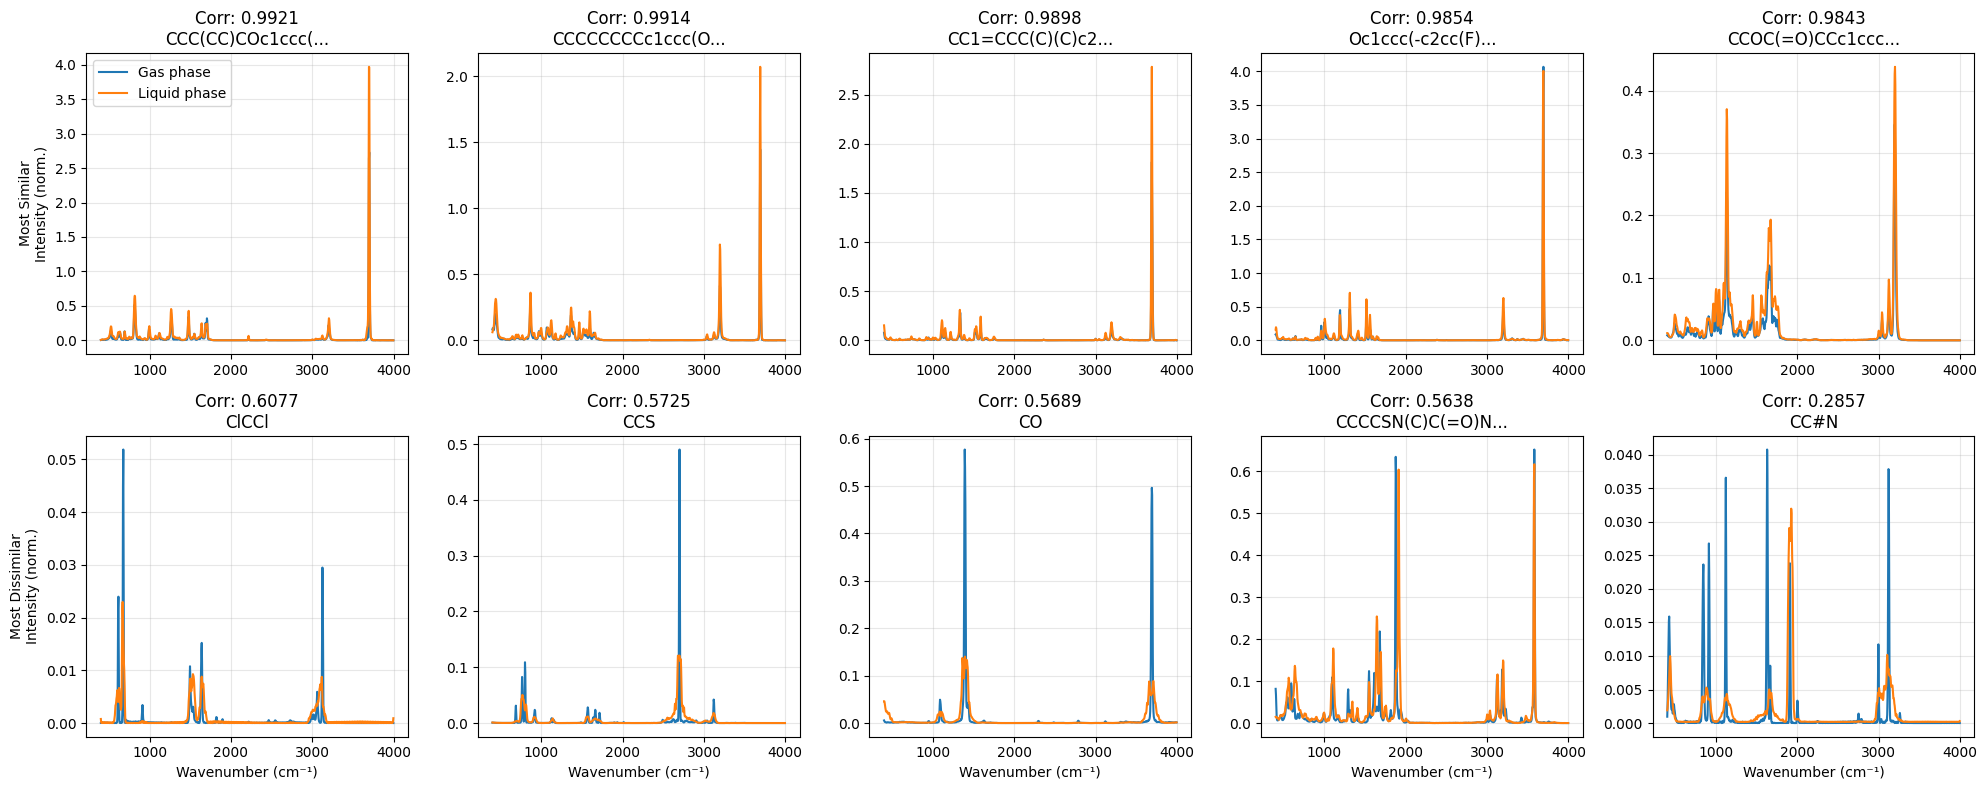

In [32]:
import matplotlib.pyplot as plt

# Find common SMILES strings between gas and liquid spectra
common_smiles = set(gas_processed_spectra.keys()).intersection(set(liquid_processed_spectra.keys()))
print(f"Found {len(common_smiles)} common molecules between gas and liquid datasets")

# Calculate correlation coefficients for all common molecules
correlations = []
for smiles in common_smiles:
    corr = corr_coefficient(gas_processed_spectra[smiles], liquid_processed_spectra[smiles])
    correlations.append((smiles, corr.item()))

# Sort by correlation coefficient (highest first)
correlations.sort(key=lambda x: x[1], reverse=True)

# Get top 5 most similar and most dissimilar
most_similar = correlations[:5]
most_dissimilar = correlations[-5:]

# Print the top 5 most similar spectra
print("Top 5 most similar gas-liquid spectra:")
for i, (smiles, corr) in enumerate(most_similar):
    print(f"{i+1}. {smiles}: {corr:.4f}")

# Print the top 5 most dissimilar spectra
print("\nTop 5 most dissimilar gas-liquid spectra:")
for i, (smiles, corr) in enumerate(most_dissimilar):
    print(f"{i+1}. {smiles}: {corr:.4f}")

# Create a 2x5 grid of plots
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
x_axis = np.arange(400, 4000, 4)  # Common wavenumber grid

# Plot the most similar spectra (top row)
for i, (smiles, corr) in enumerate(most_similar):
    ax = axes[0, i]
    ax.plot(x_axis, gas_processed_spectra[smiles], label='Gas phase')
    ax.plot(x_axis, liquid_processed_spectra[smiles], label='Liquid phase')
    ax.set_title(f'Corr: {corr:.4f}\n{smiles[:15]}{"..." if len(smiles) > 15 else ""}')
    ax.grid(True, alpha=0.3)
    if i == 0:
        ax.set_ylabel('Most Similar\nIntensity (norm.)')
    if i == 0:
        ax.legend()

# Plot the most dissimilar spectra (bottom row)
for i, (smiles, corr) in enumerate(most_dissimilar):
    ax = axes[1, i]
    ax.plot(x_axis, gas_processed_spectra[smiles], label='Gas phase')
    ax.plot(x_axis, liquid_processed_spectra[smiles], label='Liquid phase')
    ax.set_title(f'Corr: {corr:.4f}\n{smiles[:15]}{"..." if len(smiles) > 15 else ""}')
    ax.grid(True, alpha=0.3)
    if i == 0:
        ax.set_ylabel('Most Dissimilar\nIntensity (norm.)')
    ax.set_xlabel('Wavenumber (cm⁻¹)')

plt.tight_layout()
plt.show()